APR=0.064512 Sharpe=1.362926


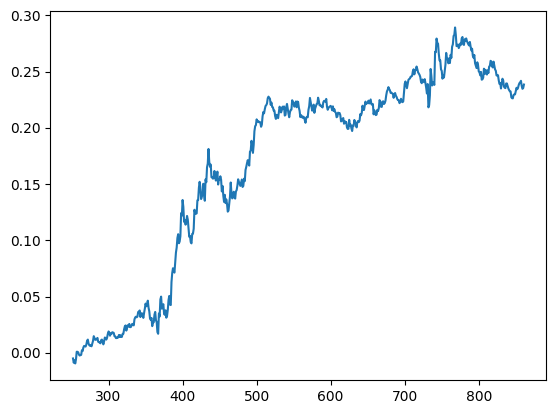

In [12]:
# Example 5.1: Pair Trading USD.AUD vs USD.CAD Using the Johansen Eigenvector

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

df1=pd.read_csv(r'/Users/educontreras/PycharmProjects/Quantitative-Finance/Algorithmic Trading - E. Chan/data/inputData_USDCAD_20120426.csv')
df1['Date']=pd.to_datetime(df1['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df1.rename(columns={'Close': 'CAD'}, inplace=True)
df1['CAD']=1/df1['CAD']

df2=pd.read_csv(r'/Users/educontreras/PycharmProjects/Quantitative-Finance/Algorithmic Trading - E. Chan/data/inputData_AUDUSD_20120426.csv')
df2['Date']=pd.to_datetime(df2['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df2.rename(columns={'Close': 'AUD'}, inplace=True)

df=pd.merge(df1, df2, how='inner', on='Date')

df.set_index('Date', inplace=True)

trainlen=250
lookback=20

hedgeRatio=np.full(df.shape, np.NaN)
numUnits=np.full(df.shape[0], np.NaN)

for t in range(trainlen+1, df.shape[0]):
    # Johansen test
    result=vm.coint_johansen(df.values[(t-trainlen-1):t-1], det_order=0, k_ar_diff=1)
    hedgeRatio[t,:]=result.evec[:, 0]
    yport=pd.DataFrame(np.dot(df.values[(t-lookback):t], result.evec[:, 0])) #  (net) market value of portfolio
    ma=yport.mean()
    mstd=yport.std()
    numUnits[t]=(-(yport.iloc[-1,:]-ma)/mstd)

positions=pd.DataFrame(np.expand_dims(numUnits, axis=1)*hedgeRatio)*df.values # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1)# daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1+ret)-1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
# APR=0.064512 Sharpe=1.362926

<AxesSubplot:>

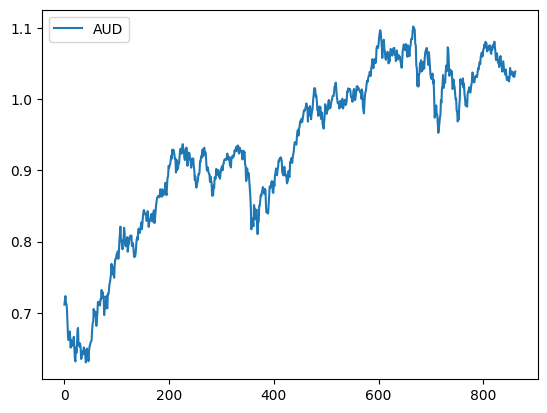

In [10]:
df2.plot()